# download useful data for nwa analysis

- aviso
- ecmwf: forecast, **era5**

**to do**


In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=14, processes=14) # a tester
    w = cluster.scale(jobs=5)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54823,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:32999,Total threads: 7
Dashboard: http://127.0.0.1:59656/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:42960,


In [3]:
root_dir = nwa.suntans_dir

m = nwa.moorings_pd.to_xarray().rename(index="mooring")
m

<xarray.Dataset>
Dimensions:    (mooring: 4)
Coordinates:
  * mooring    (mooring) object 'W310' 'N280' 'S245' 'L245'
Data variables:
    longitude  (mooring) float64 122.8 123.0 123.0 123.0
    latitude   (mooring) float64 -14.14 -14.05 -14.23 -14.23

---
## define time periods of interest and areas

In [5]:
#extract = dict(area = nwa.area_large, time=("2013/07/01", "2013/07/10")) # dev
extract = dict(area = nwa.area_large, time=("2013/07/01", "2014/07/02"))
label = "suntans"
#
extract = dict(area = nwa.area_cp, time=("2023/04/01", "2023/07/01"))
label = "cp"

---

# aviso

In [34]:
aviso_dir = "/home/ref-cmems-public/tac/sea-level/SEALEVEL_GLO_PHY_L4_MY_008_047/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D/"
aviso_dir_nrt = "/home/ref-cmems-public/tac/sea-level/SEALEVEL_GLO_PHY_L4_NRT_OBSERVATIONS_008_046/dataset-duacs-nrt-global-merged-allsat-phy-l4/"

def load_aviso(time, suffix="", nrt=False, chunks=None, rkwargs={}, **kwargs):
    """ Extract AVISO data
    Ref ...
    
    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    rkwargs: dict
        dictionary passed to xr.open_dataset
    **kwargs: dict
        passed to sel
    """
    
    if isinstance(time, tuple):
        time = pd.date_range(time[0], time[1], freq="1D")
        
    if nrt:
        aviso_dir = aviso_dir_nrt

    D = []
    for t in time:
        files = sorted(glob(os.path.join(aviso_dir, f"{t.year}/{t.dayofyear:03d}/*.nc")))
        if len(files)>1:
            # select last file for nrt products
            files = files[-1]
        #assert len(files)==1, f"error: multiple files at {files}"
        #ds = xr.open_dataset(files[0], **rkwargs).sel(**kwargs)
        # load_dataset loads data and close the file immediately while read_dataset is lazy
        # https://docs.xarray.dev/en/latest/generated/xarray.load_dataset.html
        # this choice may be more safe with regards to concurrent readings
        ds = (xr.open_mfdataset(files, **rkwargs) #concat_dim="time", 
              .sortby("latitude")
              .sel(**kwargs)
              )
        #ds = (xr.load_dataset(files[0], **rkwargs)
        #       .sel(**kwargs)
        #      )
        if chunks is not None:
            ds = ds.chunk(chunks)
        D.append(ds)
    ds = xr.concat(D, dim="time", combine_attrs="drop_conflicts") # drop attributes that vary
    ds = ds.rename(time=suffix+"time", longitude=suffix+"lon", latitude=suffix+"lat")
    return ds

In [35]:
area = extract["area"]
nrt = False

# override are for the campaign
if label=="cp":
    area = nwa.area_large
    nrt = True

ds = load_aviso(extract["time"], 
                longitude=slice(area[0], area[1]),
                latitude=slice(area[2], area[3]),
                nrt=nrt,
               )

store as a zarr archive:

In [ ]:
zarr = os.path.join(root_dir, f"aviso_{label}.zarr")
ds.to_zarr(zarr, mode="w")

or netcdf:

In [41]:
nc = os.path.join(root_dir, f"aviso_{label}.nc")
if nrt:
    nc = os.path.join(root_dir, f"aviso_{label}_nrt.nc")
ds.to_netcdf(nc, mode="w")

### Interpolate at mooring positions and store

In [51]:
dsm = ds.interp(lon=m.longitude, lat=m.latitude).compute()

In [52]:
nc = os.path.join(root_dir, f"aviso_{label}_moorings.nc")
if nrt:
    nc = os.path.join(root_dir, f"aviso_{label}_nrt_moorings.nc")
dsm.to_netcdf(nc, mode="w")

---

## ecmwf

Uses forecast for now until analysis data is available on datarmor

In [8]:
# 2019-2023
ecmwf_dir = "/home/datawork-cersat-public/provider/ecmwf/forecast/hourly/0100deg/netcdf_full/"

def load_ecmwf(time, suffix="", chunks=None, rkwargs={}, **kwargs):
    """ Extract ECMWF data
    
    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    rkwargs: dict
        dictionary passed to xr.open_dataset
    **kwargs: dict
        passed to sel
    """
    
    if isinstance(time, tuple):
        time = pd.date_range(time[0], time[1], freq="1H")
    
    D = []
    for t in time:
        path_core = f"{t.year}/{t.dayofyear:03d}/*" \
                +t.strftime("%Y%m%d%H00")+"*.nc"
        files = glob(os.path.join(ecmwf_dir, path_core))
        #ds = xr.open_dataset(files[0], **rkwargs).sel(**kwargs)
        # load_dataset loads data and close the file immediately while read_dataset is lazy
        # https://docs.xarray.dev/en/latest/generated/xarray.load_dataset.html
        # this choice may be more safe with regards to concurrent readings
        ds = (xr.open_mfdataset(files, **rkwargs) #concat_dim="time", 
              .sortby("lat")
              .sel(**kwargs)
              )
        if chunks is not None:
            ds = ds.chunk(chunks)
        D.append(ds)
    ds = xr.concat(D, dim="time", combine_attrs="drop_conflicts") # drop attributes that vary
    ds = ds.rename(time=suffix+"time", longitude=suffix+"lon", latitude=suffix+"lat")
    ds = ds.chunk(dict(time="auto"))
    return ds

def load_ecmwf_parallel(time, suffix="", chunks=None, rkwargs={}, **kwargs):
    """ Extract ECMWF data
    
    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    rkwargs: dict
        dictionary passed to xr.open_dataset
    **kwargs: dict
        passed to sel
    """
    
    if isinstance(time, tuple):
        time = pd.date_range(time[0], time[1], freq="1H")
    
    files = []
    for t in time:
        path_core = f"{t.year}/{t.dayofyear:03d}/*" \
                +t.strftime("%Y%m%d%H00")+"*.nc"
        files += glob(os.path.join(ecmwf_dir, path_core))

    def preprocess(ds):
        ds = ds.sortby("lat").sel(**kwargs)
        if "sstk" not in ds:
            ds["sstk"] = ds["q"] * 0. + np.NaN
        return ds
        
    dkwargs = dict(parallel=True, combine="nested", concat_dim="time",
                   preprocess=preprocess)
    dkwargs.update(**rkwargs)
    #return files
    ds = xr.open_mfdataset(files, **dkwargs) #concat_dim="time", 
    #if chunks is not None:
    #    ds = ds.chunk(chunks)
    #D.append(ds)
    #ds = xr.concat(D, dim="time", combine_attrs="drop_conflicts") # drop attributes that vary
    #ds = ds.rename(time=suffix+"time", longitude=suffix+"lon", latitude=suffix+"lat")
    #ds = ds.chunk(dict(time="auto"))
    return ds

###
era5_dir = "/home/datawork-cersat-public/provider/ecmwf/reanalyses/era5/"

def load_era5(time, v=None, suffix="", chunks=None, rkwargs={}, **kwargs):
    """ Extract ECMWF data
    
    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    rkwargs: dict
        dictionary passed to xr.open_dataset
    **kwargs: dict
        passed to sel
    """
    
    if v is None:
        ds = xr.merge([load_era5(time, v=v, suffix=suffix, chunks=chunks, 
                                 rkwargs=rkwargs, **kwargs)
                       for v in ["evaporation", "precipitation", "wind"]
                      ]
                     )
        return ds
    
    if isinstance(time, tuple):
        time = pd.date_range(time[0], time[1], freq="1H")
    
    D = []
    for t in time:
        path_core = f"{t.year}/{t.dayofyear:03d}/*" \
                +t.strftime("%Y%m%d")+"*"+t.strftime("%H0000")+"*.nc"
        files = glob(os.path.join(era5_dir, v, path_core))
        #ds = xr.open_dataset(files[0], **rkwargs).sel(**kwargs)
        # load_dataset loads data and close the file immediately while read_dataset is lazy
        # https://docs.xarray.dev/en/latest/generated/xarray.load_dataset.html
        # this choice may be more safe with regards to concurrent readings
        ds = (xr.open_mfdataset(files, **rkwargs)
              .sortby("latitude")
              .sel(**kwargs)
              )
        if chunks is not None:
            ds = ds.chunk(chunks)
        D.append(ds)
    ds = xr.concat(D, dim="time", combine_attrs="drop_conflicts") # drop attributes that vary
    ds = ds.rename(time=suffix+"time", longitude=suffix+"lon", latitude=suffix+"lat")
    ds = ds.chunk(dict(time="auto"))
    return ds


In [ ]:
#kwargs = dict(lon=slice(extract["area"][0], extract["area"][1]),
#                lat=slice(extract["area"][2], extract["area"][3]),)
#xr.open_mfdataset(ds[:1000], parallel=True, preprocess= lambda ds: ds.sortby("lat").sel(**kwargs))

In [9]:
# loads forecast
forecast=True
ds = load_ecmwf_parallel(extract["time"],
                lon=slice(extract["area"][0], extract["area"][1]),
                lat=slice(extract["area"][2], extract["area"][3]),
               )

In [10]:
#ds = ds.persist()
ds = ds.chunk(dict(time="auto")).persist()

In [15]:
nc = os.path.join(root_dir, f"ecmwf_{label}.nc")
if forecast:
    nc = os.path.join(root_dir, f"ecmwf_{label}_forecast.nc")
ds.to_netcdf(nc, mode="w")

In [18]:
# interpolate at mooring positions and store
dsm = ds.interp(lon=m.longitude, lat=m.latitude).compute()

nc = os.path.join(root_dir, f"ecmwf_{label}_moorings.nc")
if forecast:
    nc = os.path.join(root_dir, f"ecmwf_{label}_forecast_moorings.nc")
dsm.to_netcdf(nc, mode="w")

In [6]:
# reload
#nc = os.path.join(root_dir, f"ecmwf_{label}_moorings.nc")
nc = os.path.join(root_dir, f"ecmwf_{label}_forecast_moorings.nc")
dsm = xr.open_dataset(nc)

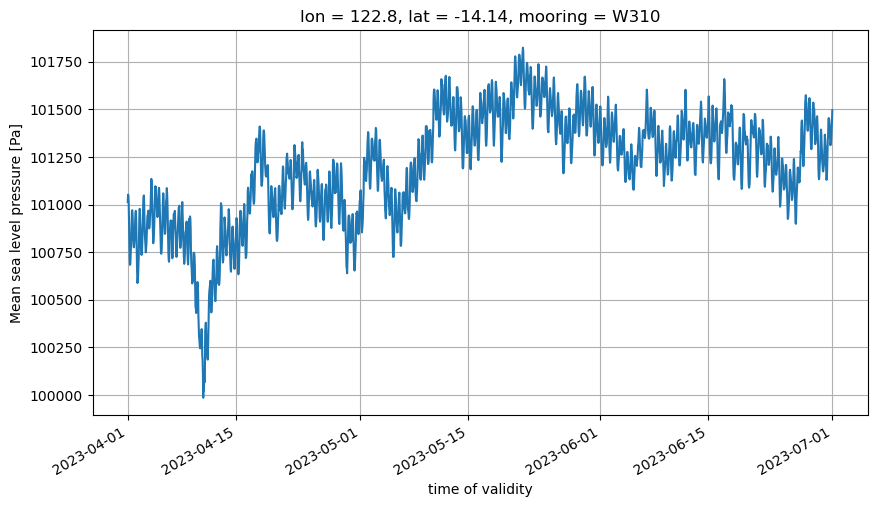

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
dsm["msl"].sel(mooring="W310").plot(ax=ax)
ax.grid()

In [ ]:
# when available
ds = load_era5(extract["time"],
                longitude=slice(extract["area"][0], extract["area"][1]),
                latitude=slice(extract["area"][2], extract["area"][3]),
               )
#ds = ds.persist()

In [52]:
nc = os.path.join(root_dir, f"aviso_{label}.nc")
ds.to_netcdf(nc, mode="w")

---

In [23]:
cluster.close()